# Import all needed packages

In [1]:
import csv
import operator
import nltk
import string
import pandas as pd
import sklearn
from tqdm import tqdm
import logging
import numpy as np
from gensim.models import word2vec, KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize, sent_tokenize, WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from numpy import asarray, zeros
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense, Dropout, CuDNNGRU, CuDNNLSTM, Bidirectional, Convolution1D, concatenate
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Flatten, Activation, SpatialDropout1D, BatchNormalization, MaxPool1D, MaxPooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint



C:\Users\MrBonBon\Miniconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\MrBonBon\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\MrBonBon\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\MrBonBon\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is de

## Clear GPU memory
I am usually out of GPU memory while running dual models

In [11]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Read and processing data

In [2]:
def read_file(filename):
    with open(r'../'+filename, encoding='utf-8') as f:
        data = f.read().split('\n')
        data = data[:len(data)-1] #Clear last null row
        f.close()
    data = [row for row in csv.reader(data, quotechar='"', delimiter=',',quoting=csv.QUOTE_ALL, skipinitialspace=True)]
    data = pd.DataFrame(data[1:], columns = data[0]) #Transform to Pandas DataFrame
    return data

def preprocess(text):
    STOPWORDS = set(stopwords.words("english"))
    text= text.strip().lower().split(' ')
    text = filter(lambda word: word not in STOPWORDS, text)
    return " ".join(text)

def categorical_label(df):
    df['EMPIRICAL'] = [1 if 'EMPIRICAL' in df.loc[i, 'Task 2'] else 0 for i in range(len(df))]
    df['ENGINEERING'] = [1 if 'ENGINEERING' in df.loc[i, 'Task 2'] else 0 for i in range(len(df))]
    df['THEORETICAL'] = [1 if 'THEORETICAL' in df.loc[i, 'Task 2'] else 0 for i in range(len(df))]
    df['OTHERS'] = [1 if 'OTHERS' in df.loc[i, 'Task 2'] else 0 for i in range(len(df))]
    
def tokenize_title():
    titles = pd.concat([train_df['Title'],test_df['Title']], ignore_index=True)
    
    #Using keras tokenizer to encode and decode 
    t = Tokenizer()
    t.fit_on_texts(titles)
    new_titles = [text_to_word_sequence(sen) for sen in titles] #new tokenizered titles
    
    #Texts to sequences
    train_titles_encoded = t.texts_to_sequences(train_df['Title'])
    test_titles_encoded = t.texts_to_sequences(test_df['Title'])
    
    #pad sequences
    max_title_len = max([len(sen) for sen in new_titles]) #max length of abstract
    train_titles_sequences = pad_sequences(train_titles_encoded, maxlen=max_title_len)
    test_titles_sequences = pad_sequences(test_titles_encoded, maxlen=max_title_len)
    
    #get word index and vocab size
    title_word_index = t.word_index
    title_vocab_size = len(title_word_index)+1
    
    #Print overview
    print('Title tokenized: \n{}\n'.format(new_titles[0]))
    print('Train titles sequences feed to Embedding layer: \n{}\n'.format(train_titles_sequences[0]))
    print('Max length of titles: {}\n'.format(max_title_len))
    print('Sample of word index: \n{}\n'.format(list(title_word_index.items())[:5]))
    print('Vocabulary size: ', title_vocab_size)
    
    return new_titles, train_titles_sequences, test_titles_sequences, max_title_len, title_word_index, title_vocab_size

def tokenize_abstract():
    abstracts = pd.concat([train_df['Abstract'],test_df['Abstract']], ignore_index=True)
    
    #Using keras tokenizer to encode and decode 
    t = Tokenizer()
    t.fit_on_texts(abstracts)
    new_abstracts = [text_to_word_sequence(sen) for sen in abstracts] #new tokenizered abtracts
    
    #Texts to sequences
    train_abstracts_encoded = t.texts_to_sequences(train_df['Abstract'])
    test_abstracts_encoded = t.texts_to_sequences(test_df['Abstract'])
    
    #pad sequences
    max_abstract_len = max([len(sen) for sen in new_abstracts]) #max length of abstract
    train_abstracts_sequences = pad_sequences(train_abstracts_encoded, maxlen=max_abstract_len)
    test_abstracts_sequences = pad_sequences(test_abstracts_encoded, maxlen=max_abstract_len)
    
    #get word index and vocab size
    abstract_word_index = t.word_index
    abstract_vocab_size = len(abstract_word_index)+1
    
    #Print overview
    print('#############################################################\n\n')
    print('Abstract tokenized: \n{}\n'.format(new_abstracts[0]))
    print('Train Abstract sequences feed to Embedding layer: \n{}\n'.format(train_abstracts_sequences[0]))
    print('Max length of abtracts: {}\n'.format(max_abstract_len))
    print('Sample of Abstract word index: \n{}\n'.format(list(abstract_word_index.items())[:5]))
    print('Abstract vocabulary size: ', abstract_vocab_size)
    
    return new_abstracts, train_abstracts_sequences, test_abstracts_sequences, max_abstract_len, abstract_word_index, abstract_vocab_size

if __name__ == "__main__":
    #read file
    train_df = read_file('task2_trainset.csv')
    test_df = read_file('task2_public_testset.csv')
    
    """
    #Use this if want to remove stopwords in Abstract
    train_df['Abstract'] = train_df['Abstract'].apply(preprocess)
    test_df['Abstract'] = test_df['Abstract'].apply(preprocess)
    """
    
    categorical_label(train_df) #Categorical label to multiple columns
    
    new_titles, train_titles_sequences,\
    test_titles_sequences, max_title_len,\
    title_word_index, title_vocab_size = tokenize_title()
    
    new_abstracts, train_abstracts_sequences,\
    test_abstracts_sequences, max_abstract_len,\
    abstract_word_index, abstract_vocab_size = tokenize_abstract()
    
    

Title tokenized: 
['a', 'brain', 'inspired', 'trust', 'management', 'model', 'to', 'assure', 'security', 'in', 'a', 'cloud', 'based', 'iot', 'framework', 'for', 'neuroscience', 'applications']

Train titles sequences feed to Embedding layer: 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    4  353  915  993  142   23   12 9123  134    5    4  121   10
  405   41    1 4205   60]

Max length of titles: 33

Sample of word index: 
[('for', 1), ('of', 2), ('and', 3), ('a', 4), ('in', 5)]

Vocabulary size:  18845
#############################################################


Abstract tokenized: 
['rapid', 'popularity', 'of', 'internet', 'of', 'things', 'iot', 'and', 'cloud', 'computing', 'permits', 'neuroscientists', 'to', 'collect', 'multilevel', 'and', 'multichannel', 'brain', 'data', 'to', 'better', 'understand', 'brain', 'functions', 'diagnose', 'diseases', 'and', 'devise', 'treatments', 'to', 'ensure', 'secure', 'and', 'reliable', 'data', 'communication',

# Load GloVe and create Embedding Matrix

In [3]:
def load_glove(dim):
    glove_vector = dict()
    f = open(r'./glove.6B/glove.6B.'+str(dim)+r'd.txt', encoding='utf-8')
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = asarray(values[1:], dtype='float32')
        glove_vector[word] = coefs
    f.close()
    print('Loaded {} word vectors'.format(len(glove_vector)))
    return glove_vector

def create_emb_mtrx(word_vector, word_index, vocab_size):
    embedding_matrix = zeros((vocab_size, 300))
    for word, i in word_index.items():
        embedding_vector = word_vector.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
    
if __name__ == "__main__":
    glove_vector = load_glove(300) #Load GloVe vector, dimension = [50,100,200,300]. I chose the largest, ok?
    embedding_matrix_title = create_emb_mtrx(glove_vector, title_word_index, title_vocab_size)
    print('Null title word embeddings: %d' % np.sum(np.sum(embedding_matrix_title, axis=1) == 0))
    print('Titles vocab size: ', title_vocab_size,'\n\n')
    
    embedding_matrix_abstract = create_emb_mtrx(glove_vector, abstract_word_index, abstract_vocab_size)
    print('Null abstract word embeddings: %d' % np.sum(np.sum(embedding_matrix_abstract, axis=1) == 0))
    print('Titles vocab size: ', abstract_vocab_size)
    
    #Free memmory
    glove_vector = []

400000it [00:35, 11238.05it/s]


Loaded 400000 word vectors
Null title word embeddings: 4218
Titles vocab size:  18845 


Null abstract word embeddings: 19416
Titles vocab size:  54775


# Build Title RNN Model
Embedding Layer -> 2 BiLSTM -> Dense -> Dense

Model: "Title model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 33)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 33, 300)           5653500   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 33, 256)           440320    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 256)               395264    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_23 (Dense)             (None, 256)               

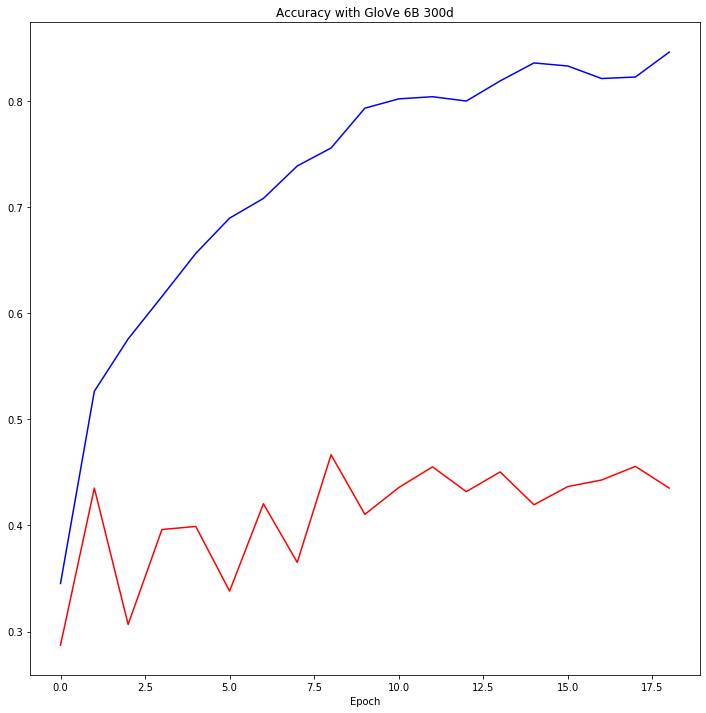

C:\Users\MrBonBon\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.73      0.62      0.67      2140
           1       0.79      0.91      0.84      3391
           2       0.80      0.88      0.84      3218
           3       0.29      0.52      0.37       259

   micro avg       0.76      0.82      0.79      9008
   macro avg       0.65      0.73      0.68      9008
weighted avg       0.76      0.82      0.79      9008
 samples avg       0.80      0.84      0.79      9008



In [14]:
def build_title_model():
    wv_layer = Embedding(embedding_matrix_title.shape[0],
                         embedding_matrix_title.shape[1],
                         #mask_zero=False,
                         #weights=[embedding_matrix_title],
                         input_length=max_title_len,
                         trainable=True)

    # Inputs
    title_input = Input(shape=(max_title_len,), dtype='int32')
    embedded_sequences = wv_layer(title_input)

    # biLSTM
    #embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(embedded_sequences)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=False))(x)

    # Multi Dense layers
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)

    #Output
    preds = Dense(4, activation='sigmoid')(x) #1 model/4 labels

    # build the model
    model = Model(inputs=[title_input], outputs=preds, name="Title model")
    model.compile(loss='categorical_crossentropy',
                  #optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def train_title_model():
    title_model = build_title_model()
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    hist = title_model.fit(X, y, 
                           validation_split=0.3, 
                           verbose=False,
                           epochs=200, 
                           batch_size=512,
                           callbacks = [es, mc],
                           shuffle=True)
    saved_model = load_model('best_model.h5')
    return saved_model, hist

def evaluate_title_model(title_model, hist):
    #Plot model accuracy
    history = pd.DataFrame(hist.history)
    plt.figure(figsize=(12,12));
    plt.plot(history["val_accuracy"], 'r');
    plt.plot(history["accuracy"], 'b');
    plt.xlabel('Epoch')
    plt.title("Accuracy with GloVe 6B 300d");
    plt.show();
    #Print report
    y_pred = title_model.predict(train_titles_sequences)
    for row in y_pred:
        for i in range(4):
            if row[i] >= 0.5:
                row[i] = 1
            else:
                row[i] = 0
    print(classification_report(y, y_pred))
    return pd.DataFrame(y_pred)
    
if __name__ == '__main__':
    X = train_titles_sequences
    y = train_df[['EMPIRICAL','ENGINEERING','THEORETICAL','OTHERS']]
    
    title_model, hist = train_title_model()
    evaluate_title_model(title_model, hist)
    predict_1 = title_model.predict(test_titles_sequences)

# Build CNN Abstract Model

C:\Users\MrBonBon\Miniconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=32, kernel_size=3)`
C:\Users\MrBonBon\Miniconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=32, kernel_size=4)`
C:\Users\MrBonBon\Miniconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=32, kernel_size=5)`


Model: "Abstract model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 511)          0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 511, 300)     16432500    input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 509, 32)      28832       embedding_16[0][0]               
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 508, 32)      38432       embedding_16[0][0]               
_____________________________________________________________________________________

Epoch 00050: early stopping


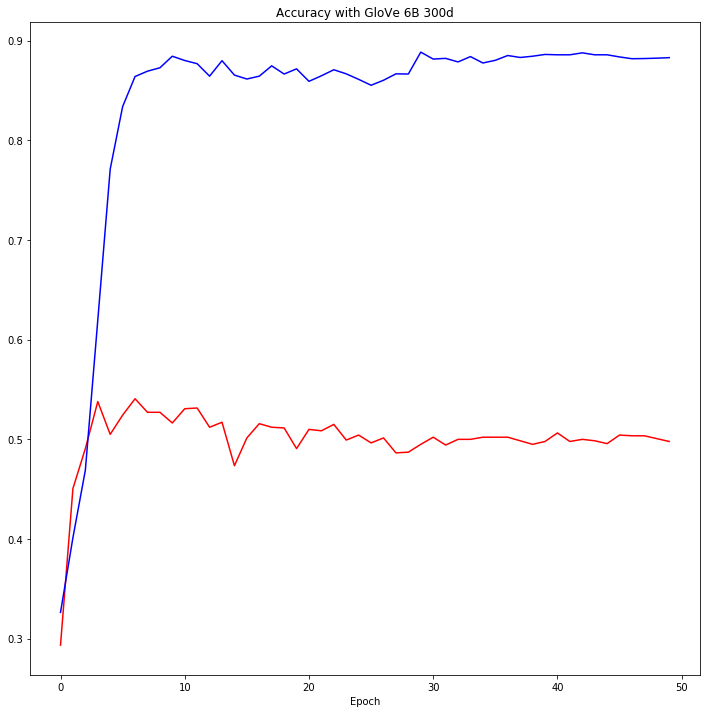

C:\Users\MrBonBon\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.91      0.84      0.87      2140
           1       0.92      0.90      0.91      3391
           2       0.95      0.89      0.92      3218
           3       1.00      0.48      0.65       259

   micro avg       0.93      0.87      0.90      9008
   macro avg       0.95      0.78      0.84      9008
weighted avg       0.93      0.87      0.90      9008
 samples avg       0.87      0.87      0.86      9008



In [19]:
def build_abstract_model():
    wv_layer = Embedding(embedding_matrix_abstract.shape[0],
                         embedding_matrix_abstract.shape[1],
                         mask_zero=False,
                         weights=[embedding_matrix_abstract],
                         input_length=max_abstract_len,
                         trainable=False)

    # Inputs
    abstract_input = Input(shape=(max_abstract_len,), dtype='int32')
    embedded_sequences = wv_layer(abstract_input)
    
    """
    # cnn1，kernel_size = 3
    cnn1_1 = Convolution1D(256, 3, padding='same')(embedded_sequences)
    cnn1_1 = BatchNormalization()(cnn1_1)
    cnn1_1 = Activation('relu')(cnn1_1)
    cnn1_1 = Dropout(0.35)(cnn1_1)
    cnn1_2 = Convolution1D(128, 3, padding='same')(cnn1_1)
    cnn1_2 = BatchNormalization()(cnn1_2)
    cnn1_2 = Activation('relu')(cnn1_2)
    cnn1_2 = Dropout(0.35)(cnn1_2)
    cnn1 = MaxPool1D(pool_size=4)(cnn1_2)

    # cnn2，kernel_size = 4
    cnn2_1 = Convolution1D(256, 4, padding='same')(embedded_sequences)
    cnn2_1 = BatchNormalization()(cnn2_1)
    cnn2_1 = Activation('relu')(cnn2_1)
    cnn2_1 = Dropout(0.35)(cnn2_1)
    cnn2_2 = Convolution1D(128, 4, padding='same')(cnn2_1)
    cnn2_2 = BatchNormalization()(cnn2_2)
    cnn2_2 = Activation('relu')(cnn2_2)
    cnn2_2 = Dropout(0.35)(cnn2_2)
    cnn2 = MaxPool1D(pool_size=4)(cnn2_2)

    # cnn3，kernel_size = 5
    cnn3_1 = Convolution1D(256, 5, padding='same')(embedded_sequences)
    cnn3_1 = BatchNormalization()(cnn3_1)
    cnn3_1 = Activation('relu')(cnn3_1)
    cnn3_1 = Dropout(0.35)(cnn3_1)
    cnn3_2 = Convolution1D(128, 5, padding='same')(cnn3_1)
    cnn3_2 = BatchNormalization()(cnn3_2)
    cnn3_2 = Activation('relu')(cnn3_2)
    cnn3_2 = Dropout(0.35)(cnn3_2)
    cnn3 = MaxPool1D(pool_size=4)(cnn3_2)

    # concatenate above 3 convolution layers
    cnn = concatenate([cnn1,cnn2,cnn3], axis=-1)
    flat = Flatten()(cnn)
    drop = Dropout(0.35)(flat)
    fc = Dense(512)(drop)
    bn = BatchNormalization()(fc)

    #Output
    main_output = Dense(4, activation='sigmoid')(bn)
    """
    
    """
    Below are new CNN models from internet
    <Start>
    """
    convs = []
    filter_sizes = [3,4,5]

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=32,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)
    
    l_merge = concatenate(convs, axis=1)
    l_flat = Flatten()(l_merge)
    l_dense = Dense(256, activation='relu')(l_flat)
    l_dense = Dense(256, activation='relu')(l_dense)
    l_dense = Dense(256, activation='relu')(l_dense)
    main_output = Dense(4, activation='sigmoid')(l_dense)
    """
    <End>
    """
    
    #Finalize model
    model = Model(inputs = abstract_input, outputs = main_output, name='Abstract model')
    
    #Complie model
    model.compile(loss='categorical_crossentropy',
                  #optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
                  optimizer = 'adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def train_abstract_model():
    abstract_model = build_abstract_model()
    es = EarlyStopping(monitor='accuracy', 
                       mode='max', 
                       verbose=1, 
                       patience=20)
    mc = ModelCheckpoint('best_model.h5', 
                         monitor='accuracy', 
                         mode='max', 
                         verbose=0, 
                         save_best_only=True)
    hist = abstract_model.fit(X, y, 
                              validation_split=0.2, 
                              verbose = 2,
                              epochs=100, 
                              batch_size=128, 
                              callbacks = [es, mc],
                              shuffle=True)
    saved_model = load_model('best_model.h5')
    return saved_model, hist

def evaluate_abstract_model(abstract_model, hist):
    #Plot model accuracy
    history = pd.DataFrame(hist.history)
    plt.figure(figsize=(12,12));
    plt.plot(history["val_accuracy"], 'r');
    plt.plot(history["accuracy"], 'b');
    plt.xlabel('Epoch')
    plt.title("Accuracy with GloVe 6B 300d");
    plt.show();
    #Print report
    y_pred = abstract_model.predict(train_abstracts_sequences)
    for row in y_pred:
        for i in range(4):
            if row[i] >= 0.5:
                row[i] = 1
            else:
                row[i] = 0
    print(classification_report(y, y_pred))
    return pd.DataFrame(y_pred)
    
if __name__ == '__main__':
    X = train_abstracts_sequences
    y = train_df[['EMPIRICAL','ENGINEERING','THEORETICAL','OTHERS']]
    
    abstract_model, hist = train_abstract_model()
    evaluate_abstract_model(abstract_model, hist)
    
    predict_2 = abstract_model.predict(test_abstracts_sequences)

In [108]:
#Get predict from 2 models and round it 
predict_1 = title_model.predict(test_titles_sequences)
predict_2 = abstract_model.predict(test_abstracts_sequences)
predict_final = (predict_1+predict_2)/2
predict_final = predict_final.round().astype(int)

#Set test dataframe to predicted value
test_df['EMPIRICAL'] = predict_final[:,0]
test_df['ENGINEERING'] = predict_final[:,1]
test_df['THEORETICAL'] = predict_final[:,2]
test_df['OTHERS'] = predict_final[:,3]


submission = pd.DataFrame(test_df[['Id','THEORETICAL','ENGINEERING','EMPIRICAL','OTHERS']])
submission = submission.rename(columns={'Id':'order_id'
                           ,'THEORETICAL':'THEORETICAL'
                           ,'ENGINEERING':'ENGINEERING'
                           ,'EMPIRICAL':'EMPIRICAL'
                           ,'OTHERS':'OTHERS'})

for i in range(len(submission)):
    if submission['OTHERS'][i]==1:
        if submission['EMPIRICAL'][i]==1 or submission['ENGINEERING'][i]==1 or submission['THEORETICAL'][i]==1:
            submission['OTHERS'][i]==0

print('Number of THEORETICAL papers: ', sum(test_df['THEORETICAL']))
print('Number of ENGINEERING papers: ', sum(test_df['ENGINEERING']))
print('Number of EMPIRICAL papers: ', sum(test_df['EMPIRICAL']))
print('Number of OTHERS papers: ', sum(test_df['OTHERS']))
print(submission[:5])


Number of THEORETICAL papers:  9209
Number of ENGINEERING papers:  7114
Number of EMPIRICAL papers:  4194
Number of OTHERS papers:  198
  order_id  THEORETICAL  ENGINEERING  EMPIRICAL  OTHERS
0   T00001            0            1          0       0
1   T00002            0            1          0       0
2   T00003            1            0          0       0
3   T00004            1            0          1       0
4   T00005            1            0          0       0


In [103]:
submission.to_csv(r'submission.csv', index=False, header=True, encoding='utf-8')